In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import re
import string
import xgboost as xgb
import seaborn as sn
import pickle

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

nltk.download('punkt')
nlp = spacy.blank('id')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_excel("dataset1000.xlsx")
df.head()

,label,komentar
0,positif,Oke pak boss!!
1,positif,PROBOWO is the WINNER of PEMILU 2014
2,positif,Hidup Pak Prabowo ..
3,positif,Ganteng bgt Pak :)
4,positif,ayo pak rujuk lagi sama bu titiek..hehhehe


In [3]:
df['label'].value_counts()

positif    1549
negatif     332
netral      120
Name: label, dtype: int64

In [4]:
komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[oke, pak, boss]"
1,positif,"[probowo, is, the, winner, of, pemilu]"
2,positif,"[hidup, pak, prabowo]"
3,positif,"[ganteng, bgt, pak]"
4,positif,"[ayo, pak, rujuk, lagi, sama, bu, titiek, hehh..."
...,...,...
1996,negatif,"[jangan, lupa, n, jangan, dugal, y, buat, yg, ..."
1997,negatif,"[no, we]"
1998,negatif,"[pasang, foto, biar, laku, ya, joko, xixixixi]"
1999,negatif,"[gw, pilih, no, prabowo, hata]"


In [5]:
df_tambahan = pd.read_excel("dataset_tambahan.xlsx")
df_tambahan

,label,komentar
0,negatif,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,negatif,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,negatif,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
3,negatif,"Dari sekian banyak thread yang aku baca, threa..."
4,negatif,"Contoh mereka yg gemar menyudutkan, teriak pal..."
...,...,...
2093,netral,bukan saya yang tidak-mau merit sat ini hubung...
2094,netral,Baru lihat kabar Teman nge gosip dan penuh inf...
2095,netral,Mengubah kebiasaan seseorang yg kurang baik it...
2096,netral,nah diam lebih bagus yaudah saya diam saja deh...


In [6]:
komentar = df_tambahan['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df_tambahan['komentar'] = komentar
df_tambahan

,label,komentar
0,negatif,"[soal, jln, jatibaru, polisi, tdk, bs, gertak,..."
1,negatif,"[sesama, cewe, lho, kayaknya, harusnya, bisa, ..."
2,negatif,"[jln, jatibaru, bagian, dari, wilayah, tn, aba..."
3,negatif,"[dari, sekian, banyak, thread, yang, aku, baca..."
4,negatif,"[contoh, mereka, yg, gemar, menyudutkan, teria..."
...,...,...
2093,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
2094,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
2095,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
2096,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [7]:
df = df[df.komentar.astype(bool)]
df_tambahan = df_tambahan[df_tambahan.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
X_train = X_train.append(df_tambahan.komentar)
y_train = y_train.append(df_tambahan.label)
y_train.value_counts()

negatif    1364
positif    1237
netral     1085
Name: label, dtype: int64

In [10]:
model = FastText.load_fasttext_format('../../cc.id.300.bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """Entry point for launching an IPython kernel.


In [11]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [12]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [13]:
lc = preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [14]:
y_train_enc = lc.transform(y_train)
y_test_enc = lc.transform(y_test)

In [15]:
weights = y_train_enc
weights = np.choose(weights, [1, 1.25, 1.1])

train=xgb.DMatrix(X_train_vector,label=y_train_enc, weight=weights)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

print("\nIni Weights\n", weights, "\n")
print("Ini y_train_encode\n", y_train_enc, "\n")


Ini Weights
 [1.25 1.25 1.   ... 1.25 1.25 1.25] 

Ini y_train_encode
 [1 1 0 ... 1 1 1] 



In [16]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000

param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.27960	test-merror:0.38945
[1]	train-merror:0.21271	test-merror:0.32663
[2]	train-merror:0.17845	test-merror:0.30402
[3]	train-merror:0.16369	test-merror:0.30402
[4]	train-merror:0.14989	test-merror:0.30905
[5]	train-merror:0.13986	test-merror:0.29397
[6]	train-merror:0.13078	test-merror:0.26884
[7]	train-merror:0.12660	test-merror:0.27136
[8]	train-merror:0.11688	test-merror:0.27889
[9]	train-merror:0.11158	test-merror:0.28643
[10]	train-merror:0.11035	test-merror:0.27889
[11]	train-merror:0.10581	test-merror:0.28895
[12]	train-merror:0.10461	test-merror:0.29146
[13]	train-merror:0.10549	test-merror:0.29146
[14]	train-merror:0.10679	test-merror:0.29146
[15]	train-merror:0.10310	test-merror:0.28141
[16]	train-merror:0.10261	test-merror:0.28141
[17]	train-merror:0.10223	test-merror:0.28895
[18]	train-merror:0.09884	test-merror:0.28895
[19]	train-merror:0.09542	test-merror:0.27889
[20]	train-merror:0.09695	test-merror:0.27387
[21]	train-merror:0.09514	test-merror:0.2788

[177]	train-merror:0.05524	test-merror:0.24372
[178]	train-merror:0.05494	test-merror:0.24372
[179]	train-merror:0.05469	test-merror:0.24372
[180]	train-merror:0.05445	test-merror:0.24372
[181]	train-merror:0.05445	test-merror:0.24372
[182]	train-merror:0.05445	test-merror:0.24372
[183]	train-merror:0.05334	test-merror:0.24372
[184]	train-merror:0.05279	test-merror:0.24372
[185]	train-merror:0.05334	test-merror:0.24623
[186]	train-merror:0.05337	test-merror:0.24623
[187]	train-merror:0.05288	test-merror:0.24874
[188]	train-merror:0.05237	test-merror:0.24623
[189]	train-merror:0.05187	test-merror:0.24874
[190]	train-merror:0.05136	test-merror:0.25126
[191]	train-merror:0.05136	test-merror:0.24874
[192]	train-merror:0.05136	test-merror:0.25126
[193]	train-merror:0.05056	test-merror:0.25126
[194]	train-merror:0.05081	test-merror:0.25126
[195]	train-merror:0.05056	test-merror:0.25126
[196]	train-merror:0.05026	test-merror:0.25126
[197]	train-merror:0.05056	test-merror:0.24874
[198]	train-m

[352]	train-merror:0.03426	test-merror:0.25377
[353]	train-merror:0.03374	test-merror:0.25377
[354]	train-merror:0.03374	test-merror:0.25377
[355]	train-merror:0.03370	test-merror:0.25377
[356]	train-merror:0.03346	test-merror:0.25377
[357]	train-merror:0.03291	test-merror:0.25377
[358]	train-merror:0.03322	test-merror:0.25377
[359]	train-merror:0.03373	test-merror:0.25377
[360]	train-merror:0.03342	test-merror:0.25377
[361]	train-merror:0.03315	test-merror:0.25377
[362]	train-merror:0.03322	test-merror:0.25377
[363]	train-merror:0.03260	test-merror:0.25377
[364]	train-merror:0.03205	test-merror:0.25377
[365]	train-merror:0.03144	test-merror:0.25377
[366]	train-merror:0.03144	test-merror:0.25377
[367]	train-merror:0.03119	test-merror:0.25377
[368]	train-merror:0.03181	test-merror:0.25377
[369]	train-merror:0.03156	test-merror:0.25377
[370]	train-merror:0.03156	test-merror:0.25377
[371]	train-merror:0.03068	test-merror:0.25377
[372]	train-merror:0.03095	test-merror:0.25377
[373]	train-m

[527]	train-merror:0.01795	test-merror:0.25126
[528]	train-merror:0.01795	test-merror:0.25126
[529]	train-merror:0.01721	test-merror:0.25126
[530]	train-merror:0.01721	test-merror:0.25126
[531]	train-merror:0.01721	test-merror:0.25126
[532]	train-merror:0.01721	test-merror:0.25126
[533]	train-merror:0.01721	test-merror:0.25126
[534]	train-merror:0.01721	test-merror:0.24874
[535]	train-merror:0.01721	test-merror:0.24874
[536]	train-merror:0.01721	test-merror:0.24874
[537]	train-merror:0.01721	test-merror:0.25126
[538]	train-merror:0.01695	test-merror:0.24874
[539]	train-merror:0.01695	test-merror:0.25126
[540]	train-merror:0.01695	test-merror:0.24874
[541]	train-merror:0.01695	test-merror:0.25126
[542]	train-merror:0.01695	test-merror:0.25126
[543]	train-merror:0.01695	test-merror:0.25126
[544]	train-merror:0.01695	test-merror:0.25126
[545]	train-merror:0.01695	test-merror:0.25126
[546]	train-merror:0.01698	test-merror:0.25126
[547]	train-merror:0.01695	test-merror:0.25377
[548]	train-m

[702]	train-merror:0.01032	test-merror:0.25628
[703]	train-merror:0.01032	test-merror:0.25628
[704]	train-merror:0.01007	test-merror:0.25628
[705]	train-merror:0.00983	test-merror:0.25628
[706]	train-merror:0.00980	test-merror:0.25628
[707]	train-merror:0.00980	test-merror:0.25628
[708]	train-merror:0.00956	test-merror:0.25628
[709]	train-merror:0.00956	test-merror:0.25628
[710]	train-merror:0.00956	test-merror:0.25628
[711]	train-merror:0.00929	test-merror:0.25628
[712]	train-merror:0.00956	test-merror:0.25628
[713]	train-merror:0.00956	test-merror:0.25628
[714]	train-merror:0.00929	test-merror:0.25628
[715]	train-merror:0.00929	test-merror:0.25628
[716]	train-merror:0.00929	test-merror:0.25628
[717]	train-merror:0.00929	test-merror:0.25628
[718]	train-merror:0.00929	test-merror:0.25628
[719]	train-merror:0.00929	test-merror:0.25628
[720]	train-merror:0.00929	test-merror:0.25628
[721]	train-merror:0.00929	test-merror:0.25628
[722]	train-merror:0.00929	test-merror:0.25628
[723]	train-m

[877]	train-merror:0.00593	test-merror:0.25377
[878]	train-merror:0.00593	test-merror:0.25377
[879]	train-merror:0.00617	test-merror:0.25377
[880]	train-merror:0.00593	test-merror:0.25377
[881]	train-merror:0.00593	test-merror:0.25377
[882]	train-merror:0.00593	test-merror:0.25377
[883]	train-merror:0.00593	test-merror:0.25377
[884]	train-merror:0.00589	test-merror:0.25377
[885]	train-merror:0.00589	test-merror:0.25377
[886]	train-merror:0.00593	test-merror:0.25377
[887]	train-merror:0.00593	test-merror:0.25377
[888]	train-merror:0.00593	test-merror:0.25377
[889]	train-merror:0.00589	test-merror:0.25377
[890]	train-merror:0.00589	test-merror:0.25377
[891]	train-merror:0.00565	test-merror:0.25377
[892]	train-merror:0.00568	test-merror:0.25377
[893]	train-merror:0.00568	test-merror:0.25377
[894]	train-merror:0.00568	test-merror:0.25377
[895]	train-merror:0.00565	test-merror:0.25377
[896]	train-merror:0.00565	test-merror:0.25377
[897]	train-merror:0.00565	test-merror:0.25377
[898]	train-m

In [17]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [18]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [19]:
test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.7462311557788944 

Train Score
 0.9945740640260445 

CONFUSSION MATRIX
 [[ 21   4  41]
 [  6   4  12]
 [ 29   9 272]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.38      0.32      0.34        66
      netral       0.24      0.18      0.21        22
     positif       0.84      0.88      0.86       310

    accuracy                           0.75       398
   macro avg       0.48      0.46      0.47       398
weighted avg       0.73      0.75      0.74       398
 



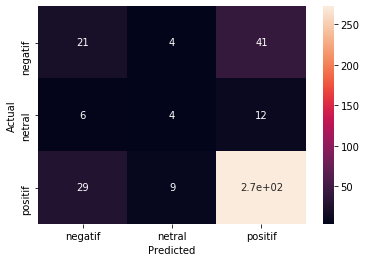

In [20]:
confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [23]:
filename = 'XGB_NegativeClassWeighting.pkl'
pickle.dump(bst, open(filename, 'wb'))

In [22]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])